In [3]:
!pip install -U folium
!pip install -U branca
!pip install geopandas

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash

In [4]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re
import requests
import json
import folium

In [5]:
data= pd.read_csv("/project/shanti_data/data.csv")

<AxesSubplot:>

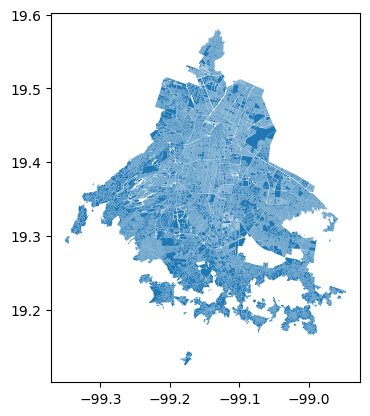

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

blocks = gpd.read_file('/project/blocks/poligono_manzanas_cdmx.shp')
blocks.plot()

plt.show()

In [ ]:
blocks.set_crs("EPSG:4326", inplace=True)

In [ ]:
from shapely.geometry import Point
# Create a GeoDataFrame from your existing DataFrame
data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Set the coordinate reference system (CRS) to be the same as the blocks
# This is necessary for the spatial join to work correctly
gdf.set_crs(blocks.crs, inplace=True)

# Perform the spatial join
joined = gpd.sjoin(gdf, blocks, how='left', op='intersects')

# The result is a new GeoDataFrame that includes all columns from the original DataFrame,
# plus additional columns for each attribute in the shapefile for the block that each point falls within.

## Zoom into the Downtown 

<AxesSubplot:>

<AxesSubplot:>

(-99.1, -99.2)

(19.4, 19.5)

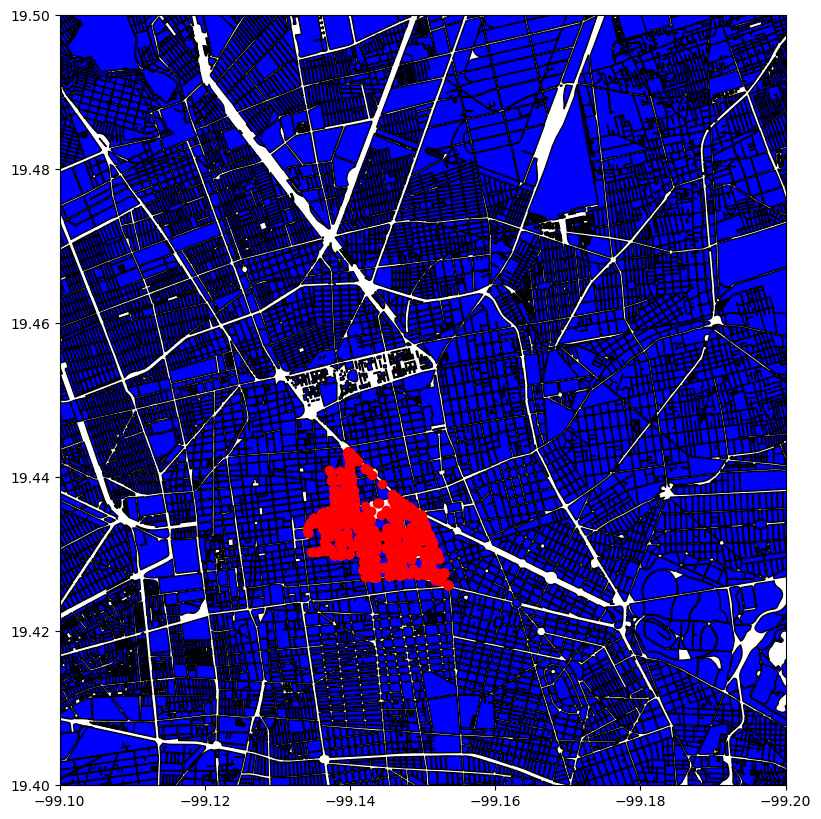

In [132]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')


ax.set_xlim([-99.10, -99.20])
ax.set_ylim([19.4, 19.5])

plt.show()


## Zoom in more

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

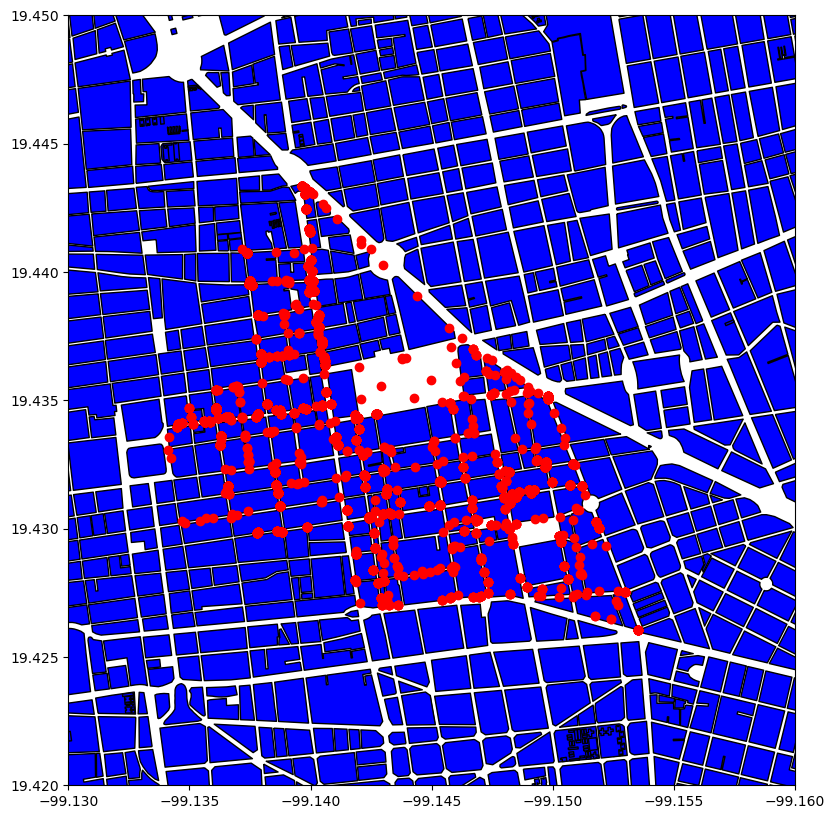

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])

plt.show()



In [ ]:
gdf.geometry.is_valid.count

In [12]:
print(joined['index_right'].isna().sum())
print(joined['index_right'].count())

7628
4056


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

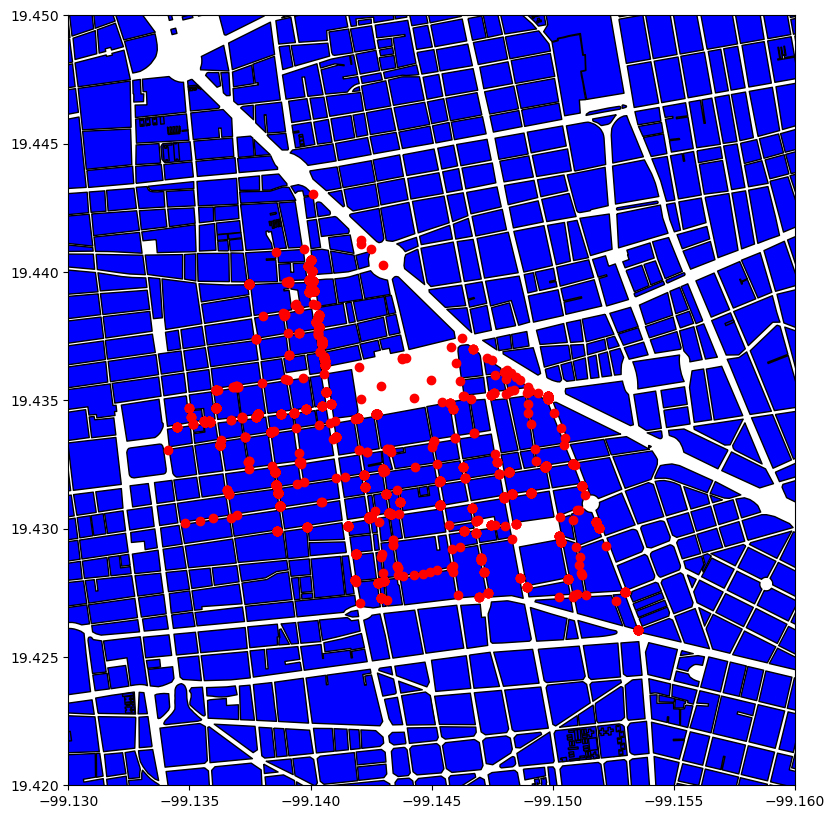

In [13]:
unmatched = gdf[joined['index_right'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the unmatched points
unmatched.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()



Since the points are falling on the streets and not within the blocks, we will use a buffer around the points to include a surrounding area, which may intersect with the blocks. This can help accommodate points that fall on the streets but are still functionally "within" a block. The currentcoordinate system EPSG:4326, which uses degrees as its unit. This is not the most intuitive approach when trying to create a buffer. We will convert to Universal Transverse Mercator which uses meters instead of degrees. The UTM Zone for Mexico City is EPSG code 32614.

In [14]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf1 = gpd.GeoDataFrame(data, geometry='geometry')
gdf1 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf1['geometry'] = gdf1.geometry.buffer(5) # 5 meters as buffer size

# Re-do the spatial join
joined1 = gpd.sjoin(gdf1, blocks, how='left', op='intersects')


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Let's compare NaN values and plot again.

In [15]:
print(joined1['index_right'].isna().sum())
print(joined1['index_right'].count())

1939
10435


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

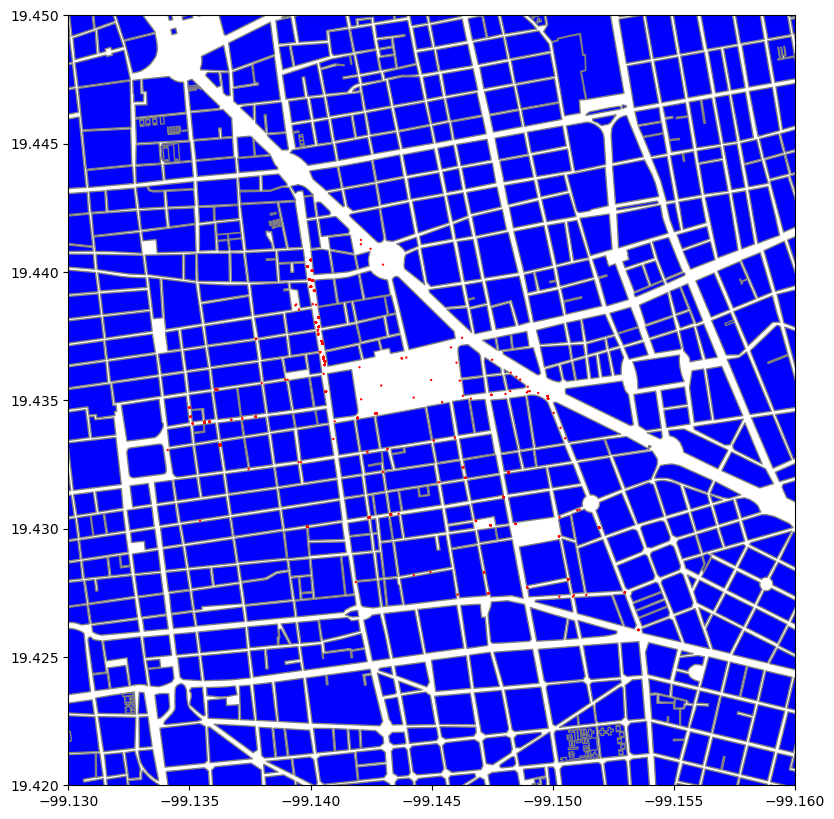

In [16]:
blocks = blocks.to_crs(epsg=4326)


unmatched1 = joined1[joined1['index_right'].isna()]
unmatched1 = unmatched1.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched1.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()

We can see that there are few points that are not matched to a block. We will do the join again with a buffer size of 15 meters to assign points on streets to blocks. However, if there are unmatched points after buffer=15, we will not increase the buffer size any further. This is because if the buffer size is too large then points may be assigned to multiple blocks, which would introduce bias into our analysis later on.

In [17]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf2 = gpd.GeoDataFrame(data, geometry='geometry')
gdf2 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf2['geometry'] = gdf2.geometry.buffer(15) # 15 meters as buffer size

# Re-do the spatial join
joined2 = gpd.sjoin(gdf2, blocks, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
print(joined2['index_right'].isna().sum())
print(joined2['index_right'].count())

34
22464


We can see that the ratio of unmatched points to matched points is only 0.001, which is an acceptable degree.

In [19]:
unmatched_count = joined2['index_right'].isna().sum()
matched_count = joined2['index_right'].count()

# Calculate ratio
ratio = unmatched_count / matched_count

print(f"Ratio of unmatched points to matched points: {ratio}")


Ratio of unmatched points to matched points: 0.0015135327635327634


<AxesSubplot:>

<AxesSubplot:>

(-99.14, -99.155)

(19.425, 19.443)

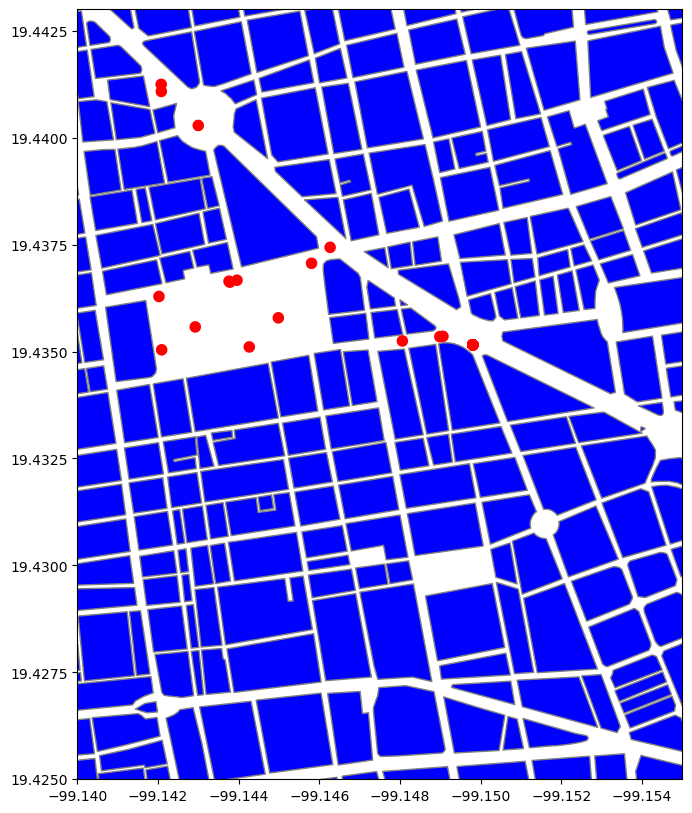

In [20]:
blocks = blocks.to_crs(epsg=4326)


unmatched2 = joined2[joined2['index_right'].isna()]
unmatched2 = unmatched2.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched2.plot(ax=ax, color='red')
ax.set_xlim([-99.140, -99.155])
ax.set_ylim([19.425, 19.443])
plt.show()

## Processing Joined 2

In [21]:
joined2.drop(['index_right','CVEGEO','CVE_ENT','CVE_MUN','CVE_LOC','CVE_AGEB','CVE_MZA',
              'AMBITO','TIPOMZA','Unnamed: 0'],
             axis=1, inplace=True)

We will remove rows where all columns apart from the 'geometry' column are identical. We do this so that the same point is not included in multiple blocks.

In [22]:
cols_to_check = joined2.columns.difference(['geometry'])
joined2 = joined2.drop_duplicates(subset=cols_to_check, keep='first')


In [23]:
joined2.head(3)

Latitude  Longitude street_name  Storefront  Visible Sign of Business  \
0  19.435848 -99.148059    Humboldt           0                         0   
1  19.435355 -99.148250    Humboldt           0                         0   
2  19.435401 -99.148391    Humboldt           0                         0   

   Business WiFi  Business tables  Business Plugs  Business Internal CCTV  \
0              0                0               0                       0   
1              0                0               0                       0   
2              0                0               0                       0   

   External CCTV  Number of female employees  Accepts credit card  \
0              0                           0                    0   
1              0                           0                    0   
2              0                           0                    0   

  Name of Business Time Open Time Close Pictures Business Owner District  \
0                0         0          0        0              0        0   
1                0         0          0        0              0        0   
2                0         0          0        0              0        0   

  Neighborhood  C_Score T_Score  Incline  Width  Ramp conditions  \
0            0      5.5       0        2      2                1   
1            0      5.5       0        2      2                1   
2            0      5.5       0        2      2                1   

   Ramp // Crosswalk  Ramp obstacles  Crosswalk width  Vertical signs  \
0                  1               0                2               0   
1                  1               0                2               0   
2                  1               0                2               0   

   Crossing length  Access to people with disabilities  W_Score  \
0                1                                   0      5.5   
1                1                                   0      5.5   
2                1                                   0      5.5   

   Broken public property  Incivility  Obstacles  \
0                       0           0          0   
1                       0           0          1   
2                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
1                                   0                    0                  0   
2                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0             0                  0             0   
1                   0             0                  0             0   
2                   0             0                  0             0   

   Vandalism  graffiti  homelessness  inclined ramp  indication of security  \
0          0         0             0              0                       0   
1          0         0             0              0                       0   
2          1         0             0              0                       0   

   mobile vendors  police presence  risky building  risky pavement  \
0               0                0               1               0   
1               0                0               1               0   
2               0                0               0               0   

   risky road  tourist map  trash  vehicle abandoned  \
0           0            0      0                  0   
1           0            0      0                  0   
2           0            0      0                  0   

   excellent street lighting  good street lighting  regular street lighting  \
0                          0                     0                        0   
1                          0                     0                        0   
2                          0                     0                        0   

   Cof

In [24]:
joined2.shape

(2410, 68)

# Join with WiFi Access Points

In [25]:
WiFi= pd.read_csv('/project/WiFi/wifi_access_points.csv')

In [26]:
WiFi.head(3)

id           programa  \
0                           19 DE MAYO-01  Colonias_sin_WiFi   
1  1A AMPLIACION SANTIAGO ACAHUALTEPEC-01  Colonias_sin_WiFi   
2  1A AMPLIACION SANTIAGO ACAHUALTEPEC-02  Colonias_sin_WiFi   

   fecha_instalacion    latitud      longitud  \
0                NaN  19.362606  -99.25295626   
1                NaN  19.352540     -99.01039   
2                NaN  19.351251  -99.00999147   

                               colonia        alcaldia  
0                           19 DE MAYO  Álvaro Obregón  
1  1A AMPLIACION SANTIAGO ACAHUALTEPEC      Iztapalapa  
2  1A AMPLIACION SANTIAGO ACAHUALTEPEC      Iztapalapa

We only need the latitudes and longitudes from this dataset, so we will drop all other columns.

In [27]:
WiFi.drop(['id','programa','fecha_instalacion','colonia','alcaldia'],
             axis=1, inplace=True)

We will now create a new DataFrame for unique combinations of latitude and longitude to count how many WiFi points there are for each coordinate.

In [28]:
WiFi_counts = WiFi.groupby(['latitud', 'longitud']).size().reset_index(name='WiFi')
WiFi_counts.head(3)

latitud   longitud  WiFi
0  19.12339  -99.18389     1
1  19.13010     -99.18     1
2  19.13020   -99.1802     1

In [29]:
WiFi_counts.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude'}, inplace=True)

In [30]:
WiFi_counts.head(3)

Latitude  Longitude  WiFi
0  19.12339  -99.18389     1
1  19.13010     -99.18     1
2  19.13020   -99.1802     1

We will clean up the coordinates by removing spaces and other non-digit, non-dot characters, converting them into float type.

In [31]:
def clean_coordinate(coord):
    # Check if it is a negative number
    if str(coord).strip().startswith('-'):
        is_negative = True
    else:
        is_negative = False

    # Keep only digits and dots
    cleaned = ''.join(ch for ch in str(coord) if ch.isdigit() or ch == '.')

    # Convert to float
    try:
        if is_negative:
            return -float(cleaned)
        else:
            return float(cleaned)
    except ValueError:
        # Return NaN if the conversion fails
        return np.nan




In [32]:
WiFi_counts['Latitude'] = WiFi_counts['Latitude'].apply(clean_coordinate)
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(clean_coordinate)


In [33]:
def make_negative(number):
    return -abs(number)


In [34]:
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(make_negative)


For the WiFi points we use a larger buffer size as the data is not as granular, as WiFi access points have a wide range where they provide access to.

In [35]:
# Convert the CRS of your geodataframes to EPSG:32614
WiFi_counts['geometry'] = WiFi_counts.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_wifi = gpd.GeoDataFrame(WiFi_counts, geometry='geometry', crs="EPSG:4326")
gdf_wifi = gdf_wifi.to_crs(epsg=32614)
joined2 = joined2.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_wifi['geometry'] = gdf_wifi.geometry.buffer(60) # 60 meters as buffer size

# Re-do the spatial join
joined_wifi = gpd.sjoin(joined2,gdf_wifi, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [36]:
joined_wifi.head()

Latitude_left  Longitude_left street_name  Storefront  \
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
1      19.435355      -99.148250    Humboldt           0   
2      19.435401      -99.148391    Humboldt           0   

   Visible Sign of Business  Business WiFi  Business tables  Business Plugs  \
0                         0              0                0               0   
0                         0              0                0               0   
0                         0              0                0               0   
1                         0              0                0               0   
2                         0              0                0               0   

   Business Internal CCTV  External CCTV  Number of female employees  \
0                       0              0                           0   
0                       0              0                           0   
0                       0              0                           0   
1                       0              0                           0   
2                       0              0                           0   

   Accepts credit card Name of Business Time Open Time Close Pictures  \
0                    0                0         0          0        0   
0                    0                0         0          0        0   
0                    0                0         0          0        0   
1                    0                0         0          0        0   
2                    0                0         0          0        0   

  Business Owner District Neighborhood  C_Score T_Score  Incline  Width  \
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
1              0        0            0      5.5       0        2      2   
2              0        0            0      5.5       0        2      2   

   Ramp conditions  Ramp // Crosswalk  Ramp obstacles  Crosswalk width  \
0                1                  1               0                2   
0                1                  1               0                2   
0                1                  1               0                2   
1                1                  1               0                2   
2                1                  1               0                2   

   Vertical signs  Crossing length  Access to people with disabilities  \
0               0                1                                   0   
0               0                1                                   0   
0               0                1                                   0   
1               0                1                                   0   
2               0                1                                   0   

   W_Score  Broken public property  Incivility  Obstacles  \
0      5.5                       0           0          0   
0      5.5                       0           0          0   
0      5.5                       0           0          0   
1      5.5                       0           0          1   
2      5.5                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   
1                                   0                    0                  0   
2                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0       

In [37]:
gdf_wifi.head()

Latitude  Longitude  WiFi  \
0  19.123390 -99.183890     1   
1  19.130100 -99.180000     1   
2  19.130200 -99.180200     1   
3  19.131999 -99.170721     1   
4  19.134200 -99.172300     1   

                                            geometry  
0  POLYGON ((480719.882 2114490.542, 480719.593 2...  
1  POLYGON ((481129.767 2115232.576, 481129.478 2...  
2  POLYGON ((481108.745 2115243.662, 481108.456 2...  
3  POLYGON ((482105.828 2115441.721, 482105.539 2...  
4  POLYGON ((481940.009 2115685.424, 481939.720 2...

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.425, 19.443)

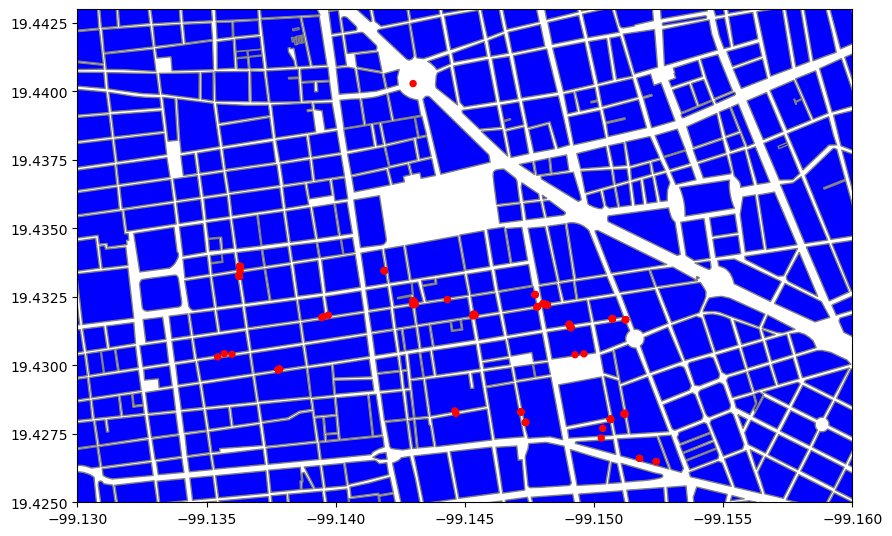

In [38]:


unmatched_wifi = joined_wifi[joined_wifi['index_right'].isna()]
unmatched_wifi = unmatched_wifi.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)

blocks.plot(ax=ax, color='blue', edgecolor='grey')
# Plot the unmatched points
unmatched_wifi.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.show()


In [39]:
print(joined_wifi['index_right'].isna().sum())
print(joined_wifi['index_right'].count())

215
3961


We will now remove duplicate rows.

In [40]:
cols_to_check_wifi = joined_wifi.columns.difference(['geometry'])
joined_wifi = joined_wifi.drop_duplicates(subset=cols_to_check_wifi, keep='first')

In [41]:
joined_wifi.head(3)

Latitude_left  Longitude_left street_name  Storefront  \
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   

   Visible Sign of Business  Business WiFi  Business tables  Business Plugs  \
0                         0              0                0               0   
0                         0              0                0               0   
0                         0              0                0               0   

   Business Internal CCTV  External CCTV  Number of female employees  \
0                       0              0                           0   
0                       0              0                           0   
0                       0              0                           0   

   Accepts credit card Name of Business Time Open Time Close Pictures  \
0                    0                0         0          0        0   
0                    0                0         0          0        0   
0                    0                0         0          0        0   

  Business Owner District Neighborhood  C_Score T_Score  Incline  Width  \
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   

   Ramp conditions  Ramp // Crosswalk  Ramp obstacles  Crosswalk width  \
0                1                  1               0                2   
0                1                  1               0                2   
0                1                  1               0                2   

   Vertical signs  Crossing length  Access to people with disabilities  \
0               0                1                                   0   
0               0                1                                   0   
0               0                1                                   0   

   W_Score  Broken public property  Incivility  Obstacles  \
0      5.5                       0           0          0   
0      5.5                       0           0          0   
0      5.5                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0             0                  0             0   
0                   0             0                  0             0   
0                   0             0                  0             0   

   Vandalism  graffiti  homelessness  inclined ramp  indication of security  \
0          0         0             0              0                       0   
0          0         0             0              0                       0   
0          0         0             0              0                       0   

   mobile vendors  police presence  risky building  risky pavement  \
0               0                0               1               0   
0               0                0               1               0   
0               0                0               1               0   

   risky road  tourist map  trash  vehicle abandoned  \
0           0            0      0                  0   
0           0            0      0                  0   
0           0            0      0                  0   

   excellent street lighting  good street lighting  regular street lighting  \
0                          0                     0                        0   
0                          0                     0                        0   
0                          0                     

We also don't need the exact coordinates of the wifi access points, hence we will drop these columns.

In [42]:
joined_wifi.drop(['index_right','Latitude_right','Longitude_right'],
             axis=1, inplace=True)

In [43]:
joined_wifi.rename(columns={'Latitude_left': 'Latitude', 'Longitude_left':'Longitude',
                           'WiFi':'Public WiFi'}, inplace=True)

# Join with Electric Bike Points

In [44]:
bikes = pd.read_csv('/project/bikes/electrict_bike_points.csv')

In [45]:
bikes.head(3)

sistema  num_cicloestacion                        nombre   calle_principal  \
0  ECOBICI                  1         Río Sena - Río Balsas          Río Sena   
1  ECOBICI                  2  Río Guadalquivir - Río Nazas  Río Guadalquivir   
2  ECOBICI                  3         Reforma - Insurgentes           Reforma   

  calle_secundaria     colonia    alcaldia   latitud   longitud tipo_ce  \
0       Río Balsas  Cuauhtémoc  CUAUHTEMOC  19.43359 -99.167819      4G   
1        Río Nazas  Cuauhtémoc  CUAUHTEMOC  19.43051 -99.171201      3G   
2      Insurgentes  Tabacalera  CUAUHTEMOC  19.43163 -99.158547      4G   

   candados  
0        27  
1        21  
2        36

In [46]:
bikes['colonia'].unique()

array(['Cuauhtémoc', 'Tabacalera', 'Juárez', 'Centro', 'Roma Norte',
       'Condesa', 'Hipódromo', 'Hipódromo Condesa', 'San Rafael',
       'Doctores', 'Roma Sur', 'Escandón', 'Buenavista',
       'San Miguel Chapultepec', 'Bosque de Chapultepec', 'Granada',
       'Polanco', 'Anzures', 'Narvarte Poniente', 'Del Valle Norte',
       'Nápoles', 'San Pedro de los Pinos', 'Del Valle Centro',
       'Ampliación Nápoles', 'Del valle Centro', 'Insurgentes San Borja',
       'Ciudad de los Deportes', 'Nonoalco', 'Noche Buena',
       'Extremadura Insurgentes', 'Tlacoquemécatl del Valle',
       'Del Valle Sur', 'Letrán Valle', 'Insurgentes Mixcoac', 'Actipan',
       'Santa Cruz Atoyac', 'Portales Norte', 'Residencial Emperadores',
       'Centro Urbano Presidente Alemán', 'Acacias', 'Xoco',
       'General Pedro María Anaya',
       'Lomas de Chapultepec Sección IV/Lomas Virreyes', 'Molino del Rey',
       'Lomas de Chapultepec Sección V',
       'Lomas de Chapultepec Sección III',
       

We will only keep the DownTown Mexico City as our area, as the base dataframe only includes data for this area.

In [47]:
bikes = bikes[bikes['colonia'] == 'Centro']


We only need the coordinates and the number of bike stations (locks) for each location. Therefore we will drop the other columns.

In [48]:
bikes.drop(['sistema','num_cicloestacion','nombre','calle_principal','calle_secundaria',
            'colonia','alcaldia','tipo_ce'],
             axis=1, inplace=True)

We will then clean the coordinates.

In [49]:
bikes.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude','candados': 'number of bikes'}, inplace=True)

In [50]:
bikes['Latitude'] = bikes['Latitude'].apply(clean_coordinate)
bikes['Longitude'] = bikes['Longitude'].apply(clean_coordinate)

In [51]:
# Convert the CRS of your geodataframes to EPSG:32614
bikes['geometry'] = bikes.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_bikes = gpd.GeoDataFrame(bikes, geometry='geometry', crs="EPSG:4326")
gdf_bikes = gdf_bikes.to_crs(epsg=32614)
joined_wifi = joined_wifi.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_bikes['geometry'] = gdf_bikes.geometry.buffer(300) # 60 meters as buffer size

# Do the spatial join
joined_bikes = gpd.sjoin(joined_wifi,gdf_bikes, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


The number of stations that have not been joined is high, however this makes sense as the number of bike stations are expected to be considerably less than the other factors we have in the data.

In [52]:
print(joined_bikes['index_right'].isna().sum())
print(joined_bikes['index_right'].count())

522
8055


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.425, 19.443)

Text(0.5, 1.0, 'Bike Access Points')

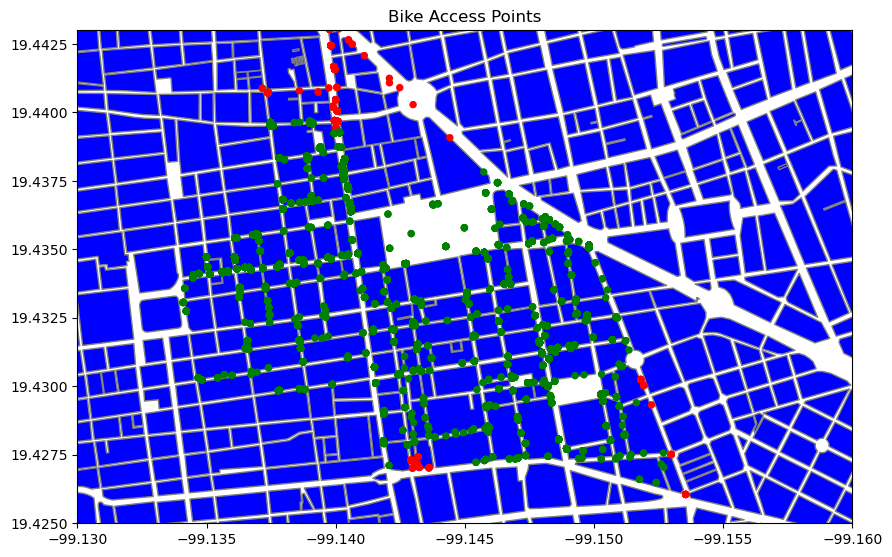

In [53]:
unmatched_bike = joined_bikes[joined_bikes['index_right'].isna()]
unmatched_bike = unmatched_bike.to_crs(epsg=4326)

matched_bike = joined_bikes[joined_bikes['index_right'].notna()]
matched_bike = matched_bike.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched_bike.plot(ax=ax, color='red')

# Plot the matched points
matched_bike.plot(ax=ax, color='green')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Bike Access Points')
plt.show()


We will now remove duplicate columns.

In [54]:
cols_to_check_bikes = joined_bikes.columns.difference(['geometry'])
joined_bikes = joined_bikes.drop_duplicates(subset=cols_to_check_bikes, keep='first')

In [55]:
joined_bikes.head()

Latitude_left  Longitude_left street_name  Storefront  \
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
0      19.435848      -99.148059    Humboldt           0   
1      19.435355      -99.148250    Humboldt           0   

   Visible Sign of Business  Business WiFi  Business tables  Business Plugs  \
0                         0              0                0               0   
0                         0              0                0               0   
0                         0              0                0               0   
0                         0              0                0               0   
1                         0              0                0               0   

   Business Internal CCTV  External CCTV  Number of female employees  \
0                       0              0                           0   
0                       0              0                           0   
0                       0              0                           0   
0                       0              0                           0   
1                       0              0                           0   

   Accepts credit card Name of Business Time Open Time Close Pictures  \
0                    0                0         0          0        0   
0                    0                0         0          0        0   
0                    0                0         0          0        0   
0                    0                0         0          0        0   
1                    0                0         0          0        0   

  Business Owner District Neighborhood  C_Score T_Score  Incline  Width  \
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
0              0        0            0      5.5       0        2      2   
1              0        0            0      5.5       0        2      2   

   Ramp conditions  Ramp // Crosswalk  Ramp obstacles  Crosswalk width  \
0                1                  1               0                2   
0                1                  1               0                2   
0                1                  1               0                2   
0                1                  1               0                2   
1                1                  1               0                2   

   Vertical signs  Crossing length  Access to people with disabilities  \
0               0                1                                   0   
0               0                1                                   0   
0               0                1                                   0   
0               0                1                                   0   
1               0                1                                   0   

   W_Score  Broken public property  Incivility  Obstacles  \
0      5.5                       0           0          0   
0      5.5                       0           0          0   
0      5.5                       0           0          0   
0      5.5                       0           0          0   
1      5.5                       0           0          1   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   
1                                   0                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0       

In [56]:
joined_bikes.drop(['index_right','Latitude_right','Longitude_right'],
             axis=1, inplace=True)

In [57]:
joined_bikes.rename(columns={'Latitude_left': 'Latitude', 'Longitude_left':'Longitude'}, inplace=True)

# Join with Inhabitants

In [116]:
inhabitants = gpd.read_file('/project/inhabitants/us_8.shp')

In [120]:
inhabitants.head(20)

cve_ent      alcaldia cve_col                              colonia  \
0       09  AZCAPOTZALCO  02-001                             AGUILERA   
1       09  AZCAPOTZALCO  02-002                               ALDANA   
2       09  AZCAPOTZALCO  02-005                        ANGEL ZIMBRON   
3       09  AZCAPOTZALCO  02-006                               ARENAL   
4       09  AZCAPOTZALCO  02-007               CENTRO DE AZCAPOTZALCO   
5       09  AZCAPOTZALCO  02-008                             CLAVERIA   
6       09  AZCAPOTZALCO  02-009                             COLTONGO   
7       09  AZCAPOTZALCO  02-011                   COSMOPOLITA (AMPL)   
8       09  AZCAPOTZALCO  02-013             CUITLÁHUAC 1 Y 2 (U HAB)   
9       09  AZCAPOTZALCO  02-014             CUITLÁHUAC 3 Y 4 (U HAB)   
10      09  AZCAPOTZALCO  02-015                              DEL GAS   
11      09  AZCAPOTZALCO  02-016                       DEL GAS (AMPL)   
12      09  AZCAPOTZALCO  02-017                          DEL MAESTRO   
13      09  AZCAPOTZALCO  02-018                           DEL RECREO   
14      09  AZCAPOTZALCO  02-020  ECOLOGICA NOVEDADES IMPACTO (U HAB)   
15      09  AZCAPOTZALCO  02-021           EL JAGUEY-ESTACION PANTACO   
16      09  AZCAPOTZALCO  02-023                 EL ROSARIO A (U HAB)   
17      09  AZCAPOTZALCO  02-024                 EL ROSARIO B (U HAB)   
18      09  AZCAPOTZALCO  02-025                 EL ROSARIO C (U HAB)   
19      09  AZCAPOTZALCO  02-026                              EUZKADI   

    MEAN_HACIN  C_HACINAM  ID  \
0     0.846000          4   1   
1     0.885000          4   2   
2     0.778333          3   3   
3     0.854054          4   4   
4     0.575625          2   5   
5     0.585055          2   6   
6     0.929048          4   7   
7     0.616471          2   8   
8     0.558889          2   9   
9     0.549634          2  10   
10    0.702800          3  11   
11    0.404375          1  12   
12    0.620000          2  13   
13    0.682917          2  14   
14    0.783846          3  15   
15    0.632222          2  16   
16    0.814773          4  17   
17    0.716813          3  18   
18    0.537328          2  19   
19    0.775238          3  20   

                                             geometry  
0   POLYGON ((483311.618 2153254.848, 483332.006 2...  
1   POLYGON ((484406.956 2153012.331, 484401.132 2...  
2   POLYGON ((480275.324 2152244.351, 480267.968 2...  
3   POLYGON ((484061.118 2152622.284, 484061.678 2...  
4   POLYGON ((480104.707 2154525.214, 480118.178 2...  
5   POLYGON ((480323.635 2152786.517, 480441.701 2...  
6   POLYGON ((484377.983 2154055.376, 484452.496 2...  
7   POLYGON ((483311.618 2153254.848, 483315.132 2...  
8   POLYGON ((482476.131 2153203.258, 482550.541 2...  
9   POLYGON ((482080.823 2153284.780, 482101.897 2...  
10  POLYGON ((483887.486 2153038.087, 483873.974 2...  
11  POLYGON ((483289.369 2152719.448, 483341.486 2...  
12  POLYGON ((480806.503 2154401.927, 480818.190 2...  
13  POLYGON ((480356.502 2153650.953, 480515.343 2...  
14  POLYGON ((480117.523 2157091.693, 480061.238 2...  
15  POLYGON ((482289.730 2155141.691, 482296.028 2...  
16  POLYGON ((478027.005 2157146.872, 477869.616 2...  
17  POLYGON ((478449.089 2157159.353, 478449.445 2...  
18  POLYGON ((479344.016 2157435.180, 479322.191 2...  
19  POLYGON ((482638.513 2153649.014, 482623.638 2...

In [122]:
inhabitants.drop(['cve_ent','alcaldia','cve_col','colonia','C_HACINAM','ID'],
             axis=1, inplace=True)

In [123]:
joined_bikes = joined_bikes.to_crs(epsg=32614)
inhabitants= inhabitants.to_crs(epsg=32614)
# Create a buffer around your points
# Here, the buffer size is in meters
inhabitants['geometry'] = inhabitants.geometry.buffer(30) # 60 meters as buffer size

# Re-do the spatial join
joined_inhabitants = gpd.sjoin(joined_bikes,inhabitants, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [124]:
print(joined_inhabitants['index_right'].isna().sum())
print(joined_inhabitants['index_right'].count())

0
6973


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.425, 19.443)

Text(0.5, 1.0, 'Inhabitants')

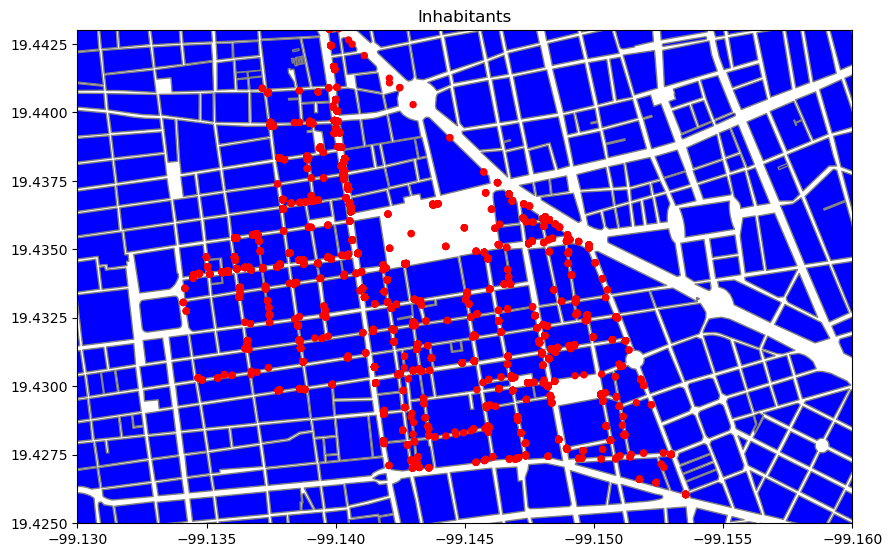

In [135]:
blocks = blocks.to_crs(epsg=4326)
joined_bikes = joined_bikes.to_crs(epsg=4326)
inhabitants= inhabitants.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

inhabitants_p = joined_inhabitants[joined_inhabitants['index_right'].notna()]
inhabitants_p = inhabitants_p.to_crs(epsg=4326)

# Plot the points
inhabitants_p.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])
plt.title('Inhabitants')
plt.show()



In [136]:
joined_inhabitants.head(3)

Latitude  Longitude street_name  Storefront  Visible Sign of Business  \
0  19.435848 -99.148059    Humboldt           0                         0   
0  19.435848 -99.148059    Humboldt           0                         0   
0  19.435848 -99.148059    Humboldt           0                         0   

   Business WiFi  Business tables  Business Plugs  Business Internal CCTV  \
0              0                0               0                       0   
0              0                0               0                       0   
0              0                0               0                       0   

   External CCTV  Number of female employees  Accepts credit card  \
0              0                           0                    0   
0              0                           0                    0   
0              0                           0                    0   

  Name of Business Time Open Time Close Pictures Business Owner District  \
0                0         0          0        0              0        0   
0                0         0          0        0              0        0   
0                0         0          0        0              0        0   

  Neighborhood  C_Score T_Score  Incline  Width  Ramp conditions  \
0            0      5.5       0        2      2                1   
0            0      5.5       0        2      2                1   
0            0      5.5       0        2      2                1   

   Ramp // Crosswalk  Ramp obstacles  Crosswalk width  Vertical signs  \
0                  1               0                2               0   
0                  1               0                2               0   
0                  1               0                2               0   

   Crossing length  Access to people with disabilities  W_Score  \
0                1                                   0      5.5   
0                1                                   0      5.5   
0                1                                   0      5.5   

   Broken public property  Incivility  Obstacles  \
0                       0           0          0   
0                       0           0          0   
0                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0             0                  0             0   
0                   0             0                  0             0   
0                   0             0                  0             0   

   Vandalism  graffiti  homelessness  inclined ramp  indication of security  \
0          0         0             0              0                       0   
0          0         0             0              0                       0   
0          0         0             0              0                       0   

   mobile vendors  police presence  risky building  risky pavement  \
0               0                0               1               0   
0               0                0               1               0   
0               0                0               1               0   

   risky road  tourist map  trash  vehicle abandoned  \
0           0            0      0                  0   
0           0            0      0                  0   
0           0            0      0                  0   

   excellent street lighting  good street lighting  regular street lighting  \
0                          0                     0                        0   
0                          0                     0                        0   
0                          0                     0                        0   

   Cof

In [137]:
joined_inhabitants.drop(['index_right'],
             axis=1, inplace=True)

In [138]:
joined_inhabitants.rename(columns={'MEAN_HACIN':'Mean Inhabitants'}, inplace=True)

# Join with Employment

In [145]:
employement = gpd.read_file('/project/employment/due_empleo_polygon.shp')

MultiPolygon is a collection of polygons that may or may not spatially intersect each other. It's used when you have multiple separate areas to represent in a single feature. We will turn the MultiPolygon into separate Polygons, with the explode method in geopandas which will give each Polygon its own row in the dataframe.

In [146]:
employement.head()

VALUE                                           geometry
0    3.0  MULTIPOLYGON (((491546.723 2140756.343, 491546...
1    4.0  MULTIPOLYGON (((478746.723 2134356.343, 478746...
2    5.0  MULTIPOLYGON (((488946.723 2139556.343, 488846...
3    1.0  MULTIPOLYGON (((500046.723 2123556.343, 500046...
4    2.0  MULTIPOLYGON (((492046.723 2135556.343, 492046...

In [149]:
exploded_geom = employement.geometry.explode()
employement = employement.loc[exploded_geom.index.get_level_values(0)].copy()
employement['geometry'] = exploded_geom.values


/tmp/ipykernel_450/4050147300.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_geom = employement.geometry.explode()


In [150]:
employement.head() #the data is in EPSG code 32614

VALUE                                           geometry
0    3.0  POLYGON ((491546.723 2140756.343, 491546.723 2...
0    3.0  POLYGON ((482646.723 2146656.343, 482646.723 2...
0    3.0  POLYGON ((497546.723 2129456.343, 497546.723 2...
0    3.0  POLYGON ((486846.723 2130656.343, 486846.723 2...
0    3.0  POLYGON ((484846.723 2132156.343, 484746.723 2...